Kernel size: 8. 
1D Convolutional layer


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn import preprocessing
import tensorflow as tf
import math
from numpy import asarray
from numpy import save
from numpy import load
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Input, MaxPooling1D
from sklearn.preprocessing import StandardScaler
import os
import tempfile
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib as mpl
import sklearn

In [4]:
EPOCHS = 20
BATCH_SIZE = 16
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load dataset.
dict_train = np.load('./drive/MyDrive/MotifClassifier/train_array.npz')
x_train = np.stack(dict_train['arr_0'], axis=0)
y_flt_train = np.load('./drive/MyDrive/MotifClassifier/train_labels.npy')
y_train = y_flt_train.astype(int)-1  # Renumber the classes to #cluster-1
y_train_oh = to_categorical(y_train, num_classes=44)  # Make labels into one-hot encode. 

dict_test = np.load('./drive/MyDrive/MotifClassifier/test_array.npz')
x_test = np.stack(dict_test['arr_0'], axis=0)
y_flt_test = np.load('./drive/MyDrive/MotifClassifier/test_labels.npy')
y_test = y_flt_test.astype(int)-1  # Renumber the classes to #cluster-1
y_test_oh = to_categorical(y_test, num_classes=44)  # Make labels into one-hot encode. 

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)
print('Training labels shape:', y_train_oh.shape)
print('Test labels shape:', y_test_oh.shape)

Training features shape: (11399, 8, 4)
Test features shape: (5724, 8, 4)
Training labels shape: (11399, 44)
Test labels shape: (5724, 44)


In [5]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [6]:
print('Training labels shape:', y_train_oh.shape)
print('Test labels shape:', y_test_oh.shape)

print('Training features shape:', x_train.shape)
print('Test features shape:', x_test.shape)


Training labels shape: (11399, 44)
Test labels shape: (5724, 44)
Training features shape: (11399, 8, 4)
Test features shape: (5724, 8, 4)


In [7]:
def make_model1(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(16, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model


In [8]:
def make_model2(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(64, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(32, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model

In [9]:
def make_model3(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = Sequential([
    # The input shape is 8x4
    # This is the first convolution
    Conv1D(64, 3, strides=1, activation='relu',padding='same', #4(possible base)^3(kernal size)=64
                 input_shape=(8, 4),
                 kernel_initializer='he_normal',  
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),
    Dropout(0.2),
    Conv1D(128, 3, strides=1, activation='relu',padding='same', 
                 kernel_initializer='he_normal',
                 bias_initializer='zeros'),
    # MaxPooling1D(pool_size=2, strides=2),    
    Dropout(0.2),
    Flatten(),
    #  neuron hidden layer
    Dense(128, activation='relu', bias_initializer=output_bias, kernel_initializer='he_normal'),  #8/2(maxpooling)=4, 32*4 = 128
    Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for class ('not GNRA') and 1 for the other ('GNRA')
    Dense(44, activation='softmax', bias_initializer=output_bias, kernel_initializer='glorot_uniform')  #Softmax for multiclass classification problem. Glorot for softmax.
    ])
     
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3), #optimizer=RMSprop(lr=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=METRICS)  # Accuracy for classification problems. 
  
  return model

In [21]:
# Plot loss and accuracy.
def plot_metrics(history1, history2, history3):
  metrics = ['loss', 'accuracy']
  plt.rcParams['font.size'] = '16'
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(1,2,n+1)
    plt.plot(history1.epoch, history1.history[metric], color=colors[0], label='Conf1.2_Train')
    plt.plot(history1.epoch, history1.history['val_' + metric],
             color=colors[0], linestyle="--", label='Conf1.2_Test')
    plt.plot(history2.epoch, history2.history[metric], color=colors[1], label='Conf2.2_Train')
    plt.plot(history2.epoch, history2.history['val_' + metric],
             color=colors[1], linestyle="--", label='Conf2.2_Test')
    plt.plot(history3.epoch, history3.history[metric], color=colors[2], label='Conf3.3_Train')
    plt.plot(history3.epoch, history3.history['val_' + metric],
             color=colors[2], linestyle="--", label='Conf3.3_Test')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'accuracy':
      plt.ylim([0,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [ ]:
# Plot confusion matrix (for binary problems)
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non-GNRA Detected (True Negatives): ', cm[0][0])
  print('Non-GNRA Incorrectly Detected (False Positives): ', cm[0][1])
  print('GNRA Missed (False Negatives): ', cm[1][0])
  print('GNRA Detected (True Positives): ', cm[1][1])
  print('Total GNRA: ', np.sum(cm[1]))

In [ ]:
# Plot ROC curve.
def plot_roc(name, labels, predictions, **kwargs):
  fpr, tpr, _ = sklearn.metrics.roc_curve(labels, predictions)  # fpr=false positive rate = fp/(fp+tn), tpr=true positive rate = tp/(tp+fn)

  plt.plot(100*fpr, 100*tpr, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives rate = fp/(fp+tn)')
  plt.ylabel('True positives rate = tp/(tp+fn)')
  plt.xlim([-5,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
# Plot precision-recall curve (for binary problem)
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall  - TP / (TP + FP)')
    plt.ylabel('Precision - TP / (TP + FN)')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [11]:
# retrain with class weights
# The sum of the weights of all examples stays the same.
y_integers = np.argmax(y_train_oh, axis=1)
class_weights = np.round(class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers), 2)
d_class_weights = dict(enumerate(class_weights))
  
print(d_class_weights)

{0: 0.04, 1: 0.4, 2: 0.73, 3: 0.88, 4: 0.83, 5: 1.1, 6: 1.11, 7: 1.17, 8: 1.39, 9: 1.37, 10: 1.48, 11: 1.51, 12: 1.55, 13: 1.68, 14: 1.7, 15: 1.85, 16: 1.88, 17: 1.96, 18: 1.96, 19: 2.59, 20: 3.2, 21: 3.16, 22: 51.81, 23: 4.8, 24: 5.76, 25: 6.48, 26: 6.48, 27: 6.64, 28: 6.82, 29: 51.81, 30: 6.82, 31: 8.1, 32: 8.64, 33: 9.25, 34: 259.07, 35: 259.07, 36: 259.07, 37: 259.07, 38: 129.53, 39: 12.34, 40: 13.64, 41: 14.39, 42: 16.19, 43: 259.07}


In [12]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model1 = make_model1()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history1 = weighted_model1.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20
713/713 [==============================] - 8s 7ms/step - loss: 3.1060 - tp: 418.0000 - fp: 175.0000 - tn: 489982.0000 - fn: 10981.0000 - accuracy: 0.2193 - precision: 0.7049 - recall: 0.0367 - auc: 0.8562 - prc: 0.1935 - val_loss: 1.8789 - val_tp: 1086.0000 - val_fp: 475.0000 - val_tn: 245657.0000 - val_fn: 4638.0000 - val_accuracy: 0.4205 - val_precision: 0.6957 - val_recall: 0.1897 - val_auc: 0.9604 - val_prc: 0.4502
Epoch 2/20
713/713 [==============================] - 4s 5ms/step - loss: 1.8709 - tp: 2076.0000 - fp: 1490.0000 - tn: 488667.0000 - fn: 9323.0000 - accuracy: 0.3450 - precision: 0.5822 - recall: 0.1821 - auc: 0.9443 - prc: 0.3722 - val_loss: 1.7139 - val_tp: 1610.0000 - val_fp: 1380.0000 - val_tn: 244752.0000 - val_fn: 4114.0000 - val_accuracy: 0.3805 - val_precision: 0.5385 - val_recall: 0.2813 - val_auc: 0.9676 - val_prc: 0.4956
Epoch 3/20
713/713 [==============================] - 4s 6ms/step - loss: 1.4400 - tp: 2883.0000 - fp: 2411.0000 - tn: 487746.0000

In [13]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model2 = make_model2()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history2 = weighted_model2.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20
713/713 [==============================] - 8s 8ms/step - loss: 2.8207 - tp: 4523.0000 - fp: 2309.0000 - tn: 733980.0000 - fn: 12600.0000 - accuracy: 0.3960 - precision: 0.6620 - recall: 0.2641 - auc: 0.9287 - prc: 0.4403 - val_loss: 1.8549 - val_tp: 1214.0000 - val_fp: 925.0000 - val_tn: 245207.0000 - val_fn: 4510.0000 - val_accuracy: 0.3358 - val_precision: 0.5676 - val_recall: 0.2121 - val_auc: 0.9644 - val_prc: 0.3926
Epoch 2/20
713/713 [==============================] - 5s 6ms/step - loss: 1.6680 - tp: 2867.0000 - fp: 2179.0000 - tn: 487978.0000 - fn: 8532.0000 - accuracy: 0.3847 - precision: 0.5682 - recall: 0.2515 - auc: 0.9403 - prc: 0.4015 - val_loss: 1.2263 - val_tp: 2016.0000 - val_fp: 1267.0000 - val_tn: 244865.0000 - val_fn: 3708.0000 - val_accuracy: 0.5533 - val_precision: 0.6141 - val_recall: 0.3522 - val_auc: 0.9842 - val_prc: 0.6272
Epoch 3/20
713/713 [==============================] - 4s 6ms/step - loss: 1.0404 - tp: 3947.0000 - fp: 2974.0000 - tn: 487183.00

In [14]:
# Train the CNN model on the training set and evaluate by test set.
weighted_model3 = make_model3()
#weighted_model.load_weights(initial_weights)

# model.fit trains the model for a fixed number of epochs (iterations on a dataset).
weighted_history3 = weighted_model3.fit(
    x_train,
    y_train_oh, 
    validation_data = (x_test, y_test_oh),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,

    # The class weights go here
    class_weight=d_class_weights)

Epoch 1/20
713/713 [==============================] - 10s 10ms/step - loss: 2.1960 - tp: 7790.0000 - fp: 2739.0000 - tn: 733550.0000 - fn: 9333.0000 - accuracy: 0.5757 - precision: 0.7399 - recall: 0.4549 - auc: 0.9718 - prc: 0.6481 - val_loss: 1.0222 - val_tp: 2470.0000 - val_fp: 704.0000 - val_tn: 245428.0000 - val_fn: 3254.0000 - val_accuracy: 0.7324 - val_precision: 0.7782 - val_recall: 0.4315 - val_auc: 0.9905 - val_prc: 0.7581
Epoch 2/20
713/713 [==============================] - 7s 9ms/step - loss: 0.9932 - tp: 5113.0000 - fp: 2822.0000 - tn: 487335.0000 - fn: 6286.0000 - accuracy: 0.5703 - precision: 0.6444 - recall: 0.4485 - auc: 0.9774 - prc: 0.6243 - val_loss: 0.7870 - val_tp: 3839.0000 - val_fp: 1086.0000 - val_tn: 245046.0000 - val_fn: 1885.0000 - val_accuracy: 0.7046 - val_precision: 0.7795 - val_recall: 0.6707 - val_auc: 0.9895 - val_prc: 0.7916
Epoch 3/20
713/713 [==============================] - 8s 11ms/step - loss: 0.6476 - tp: 6858.0000 - fp: 2541.0000 - tn: 487616.

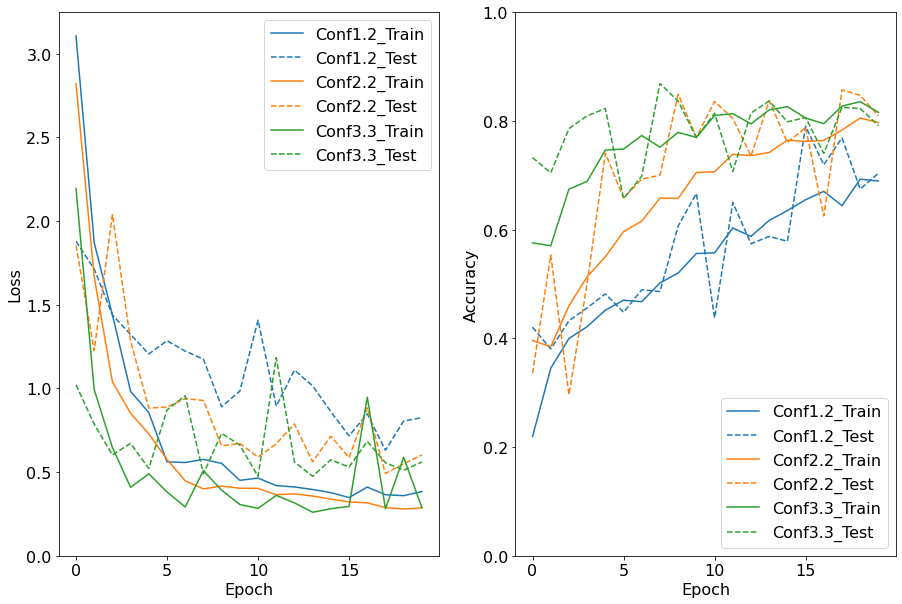

In [22]:
plot_metrics(weighted_history1, weighted_history2, weighted_history3)

In [ ]:
# Model.predict gives the predicted output. 
train_predictions_weighted = weighted_model.predict(x_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(x_test, batch_size=BATCH_SIZE)

In [ ]:
# Results of test data set. 
# model.evaluate returns the loss value & metrics values for the model in test mode (the model is already trained).
weighted_results = weighted_model.evaluate(x_test, y_test_oh,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test_oh, test_predictions_weighted)

loss :  0.567273736000061
tp :  4641.0
fp :  817.0
tn :  245315.0
fn :  1083.0
accuracy :  0.8366526961326599
precision :  0.8503114581108093
recall :  0.8107966184616089
auc :  0.9848337173461914
prc :  0.8603513240814209



ValueError: ignored

In [ ]:
plot_roc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

ValueError: ignored

In [ ]:
plot_prc("Train Weighted", y_train, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", y_test, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

ValueError: ignored